Want a simple example of learning to reinforcement learn.

https://arxiv.org/abs/1611.05763


https://hackernoon.com/learning-policies-for-learning-policies-meta-reinforcement-learning-rl%C2%B2-in-tensorflow-b15b592a2ddf

In [1]:
import numpy as np
import tensorflow as tf
import trfl

import tensorflow_probability as tfp
tfd = tfp.distributions
tf.enable_eager_execution()

import matplotlib.pyplot as plt

In [2]:
class Env():
    """
    A super simple environment to play with.
    A multi-armed bandit.
    """
    def __init__(self, n_bandits, maxsteps=100):
        self.n_bandits = n_bandits
        self.means = np.random.standard_normal(n_bandits)
        self.stddev = np.abs(np.random.standard_normal(n_bandits))
        
        self.reset()
        self.maxsteps = maxsteps
        
    def step(self, action):
        reward = self.means[action] + self.stddev[action] * 0.1*np.random.standard_normal()
        
        if self.timestep >= self.maxsteps-1:
            done = True
            self.reset()
        else:
            done = False
            self.timestep += 1
            
        return None, reward, done
    
    def reset(self):
        self.timestep = 0
        return None, 0, False
    
    def show(self):
        plt.figure(figsize=(8, 4))
        plt.title('Bandit arm values')
        plt.bar(range(self.n_bandits), self.means, 0.5, yerr=self.stddev)
        plt.xlabel('Arms')
        plt.ylabel('Payoff')

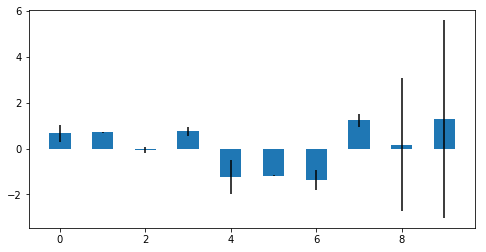

In [3]:
n_arms = 10
bandit = Env(n_arms)
bandit.show()

In [4]:
class Memory():
    def __init__(self):
        self.mem = {}
        self.counter = 0
    
    def append(self, x):
        self.mem[self.counter] = x
        self.counter += 1
            
    def get_batch(self, batch_size):
        idxs = np.random.randint(0,len(self.mem), batch_size)
        batch = [self.mem[idx] for idx in idxs]  # a list of [[obs_s, a_s, r_s], ...]
        return [np.stack(arr, axis=0) for arr in zip(*batch)]
    
    @property
    def size(self):
        return len(self.mem)

In [5]:
M = Memory()
for _ in range(10):
    M.append([2,3,4])

M.mem
list(M.get_batch(3))

[array([2, 2, 2]), array([3, 3, 3]), array([4, 4, 4])]

In [6]:
# """
# Want to baseline agaisnt a simple UCB learner with hparam tuning.
# """

# # utils
# def onehot(idx, N):
#     return np.eye(N)[idx]

# def softmax(x):
#     return np.exp(x)/np.sum(np.exp(x))

# class QLeaner():
#     def __init__(self, n_states, n_actions, util_fn):
#         self.gamma = 0.9
#         self.lr = 0.001
#         self.util_fn = util_fn

#         self.qs = np.zeros([n_states, n_actions])
        
#         self.old_s = None
#         self.old_a = None
#         self.old_r = None
    
#     def __call__(self, s, r, done):
#         a = self.util_fn(s, self.qs)
        
#         if self.old_s is not None:
#             self.train_step(self.old_s, self.old_a, self.old_r, s, a)
                
#         # loop past observations so we can use them for training
#         self.old_s = s
#         self.old_a = a
#         self.old_r = r
                
#         return a
    
#     def train_step(self, old_s, old_a, old_r, s, a):
#         target = (old_r + self.gamma*self.qs[s, a])  # bootstrap off next step. TD!
#         # wait a minute. in https://arxiv.org/abs/1807.03765 they actually update 
#         # the q values with the uncertainty estimates. delta + bt. hmph
#         # why would you combine them??? 
#         # oh. If you dont combine them then you are doing offpolicy...!?
#         delta =  target - self.qs[old_s, old_a]
#         self.qs[old_s, old_a] += self.lr * delta  # incremental update. exp avg/GD!
        
# class UCB_Hoeffding():
#     def __init__(self, n_states, action_space):
#         self.counts = np.zeros([n_states, len(action_space)])
#         self.action_space = action_space

#     def __call__(self, s, qs):
#         if s is None:
#             s = 0
#         util = qs[s, ...] + 1/np.sqrt(self.counts[s, ...]+1)  # utility = exploit + explore
#         p = softmax(util)
#         a = np.random.choice(self.action_space, p=p)

#         self.counts[s, a] += 1

#         return a
    
# player = QLeaner(1, 5, UCB_Hoeffding(1, list(range(5))))
# rs = eval_player(bandit, player, 2000)
# plt.plot(rs)

In [24]:
class RNN():
    """
    Handles sharing parameters between worker and learner RNNs.
    Need to be able to run the RNN for next step prediction, and end to end training.
    """
    def __init__(self, n_hidden, batch_size):
        self.cell = tf.nn.rnn_cell.LSTMCell(n_hidden)
        self.reset_state(batch_size)
        self.variables = self.cell.variables

    def __call__(self, x):   
        # TODO want deep RNN
        ys = []
        for t in range(x.shape[1]):
            y, self.state = self.cell(x[:, t, :], state=self.state)
            ys.append(y)
        return ys
    
    def step(self, x, state):
        return self.cell(x, state=state) 
    
    def reset_state(self, batch_size):
        self.state = self.cell.zero_state(batch_size=batch_size, dtype=tf.float32)
        return self.state
    
    
rnn = RNN(5, 2)
inputs = tf.random_normal([2, 10, 2])
output = rnn(inputs)
print([o.shape for o in output])

# output, state = rnn.step(inputs[0:1, 0, :], rnn.reset_state(1))
# print(output.shape)

[TensorShape([Dimension(2), Dimension(5)]), TensorShape([Dimension(2), Dimension(5)]), TensorShape([Dimension(2), Dimension(5)]), TensorShape([Dimension(2), Dimension(5)]), TensorShape([Dimension(2), Dimension(5)]), TensorShape([Dimension(2), Dimension(5)]), TensorShape([Dimension(2), Dimension(5)]), TensorShape([Dimension(2), Dimension(5)]), TensorShape([Dimension(2), Dimension(5)]), TensorShape([Dimension(2), Dimension(5)])]


In [25]:
class Worker():
    def __init__(self, learner, batch_size):
        self.buffer = Memory()
        self.trajectory = []
        
        self.learner = learner
        self.batch_size = batch_size
    
    def __call__(self, x, r, done, is_training=True):
        if x is None:
            x = 0
        # call policy and take action
        a, _ = self.learner(x, r)
        
        # add experience to buffer
        if done:
            self.buffer.append([np.stack(arr, axis=0) for arr in zip(*self.trajectory)])
            self.trajectory = []
        else:
            # current obs, current action, old reward
            self.trajectory.append([x, a, r])
            
        # train
        if self.buffer.size > self.batch_size and done and is_training:
            # runs a training step every episode
            self.learner.train_step(*self.buffer.get_batch(self.batch_size))
            
        return a

In [26]:
def discrete_reparam(x):
    return tfd.OneHotCategorical(logits=x).sample()

class ActorCritic():
    def __init__(self, n_actions, time_steps, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.time_steps = time_steps
        
        self.rnn = RNN(128, batch_size=batch_size)
        self.nn = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation=tf.nn.selu),
            tf.keras.layers.Dense(n_actions+1)
        ])
        self.state = self.rnn.reset_state(1)
        self.a_old = tf.constant(0, shape=[1, 1], dtype=tf.float32)
        
        self.opt = tf.train.AdamOptimizer()
        self.global_step = tf.train.get_or_create_global_step()
        
    def forward(self, inputs):
        """
        A forward function for BPTT.
        The key is that we need to be able to differentiate wrt all inputs.
        """
        # QUESTION how can the net explore? cannot take random actions
        # as it is a deterministic fn of its inputs.
        # it could enumerate the different actions and try each!?
        self.rnn.reset_state(self.batch_size)
        hs = self.rnn(inputs)
        # BUG gradients are not working!!! why!?
        zs = tf.stack(list(map(self.nn, hs)), axis=0)
        return zs[:, :,:self.n_actions], zs[:, :,self.n_actions:]
        
    def train_step(self, x, a, r):
        """
        Train on a batch of data.
        
        x: (B, T)
        a: (B, T)
        r: (B, T)
        """
        x = tf.constant(x, shape=[self.batch_size, self.time_steps, 1], dtype=tf.float32)
        a = tf.constant(a, shape=[self.batch_size, self.time_steps, 1], dtype=tf.float32)
        r = tf.constant(r, shape=[self.batch_size, self.time_steps, 1], dtype=tf.float32)

        # current obs, old action, old reward
        inputs = tf.concat([x[:, 1:, :], a[:, :-1:, ], r[:, 1:, :]], axis=-1)

        a = tf.transpose(tf.squeeze(tf.cast(a[:, 1:, :], tf.int32)))
        r = tf.transpose(r[:, 1:, 0])

        with tf.GradientTape() as tape:

            logits, v = self.forward(inputs)
            policy_loss, extra = trfl.sequence_advantage_actor_critic_loss(
                policy_logits=logits, baseline_values=v[..., 0], actions=a, 
                rewards=r, pcontinues=tf.ones_like(r), bootstrap_value=tf.reduce_sum(r, axis=0))
            policy_loss = tf.reduce_mean(extra.policy_gradient_loss)
            value_loss = tf.reduce_mean(extra.baseline_loss) 
            # tf.losses.mean_squared_error(extra.discounted_returns, v[..., 0])
            
        # BUG. rnn grads not working
        grads = tape.gradient([value_loss, policy_loss, value_loss, policy_loss], 
                              [self.nn.variables, self.nn.variables, self.rnn.variables, self.rnn.variables])
        gnvs = [(g, v) for grad, var in zip(grads, [self.nn.variables, self.nn.variables]) for g, v in zip(grad, var)]
        self.opt.apply_gradients(gnvs, global_step=self.global_step)

                    
    def __call__(self, x, r):
        """
        Choose actions online. Use the current parameters to choose an action.
        Keep the state from the last choice.
        """
        # current observation/state (x) and the r from t-1.
        x = tf.constant(x, shape=[1, 1], dtype=tf.float32)
        r = tf.constant(x, shape=[1, 1], dtype=tf.float32)

        inputs = tf.concat([x, self.a_old, r], axis=1)
        h, self.state = self.rnn.step(inputs, self.state)
        
        z = self.nn(h)
        a = tf.squeeze(tf.argmax(discrete_reparam(z[..., :-1]), axis=1))
        v = z[..., -1:]
        return a, v

In [27]:
def play_episode(player, env, is_training):
    obs, r, done = env.reset()
    total_R = 0
    while not done:
        a = player(obs, r, done, is_training)
        obs, r, done = env.step(a)
        total_R += r
    a = player(obs, r, done)
    return total_R

In [28]:
def eval_player(env, player, n_episodes, is_training=True):
    """
    Args:
        env: must have a callable env.step fn that takes [state x action)s and returns (new_state, reward)
        player: a callable fn that returns actions given the current state
        
    Returns:
        Rs: Rewards as a fn of time
    """
    Rs = []
    for i in range(n_episodes):

        r = play_episode(player, env, is_training)
        Rs.append(r)

        print('\rStep: {}, R: {}'.format(i, r), end='', flush=True)

    return Rs

In [ ]:
player = Worker(ActorCritic(n_arms, batch_size=50, time_steps=100), 50)
rs = eval_player(bandit, player, 500)
plt.plot(rs)

Step: 394, R: 76.170436582987132

In [ ]:
# make a new bandit and evaluate
bandit = Env(n_arms)
rs = eval_player(bandit, player, 100, is_training=False)
plt.plot(rs)

Step: 399, R: -2.75787198537116683

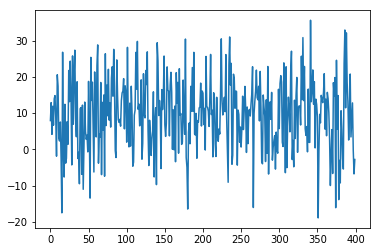

In [13]:
player = lambda x, y, z: np.random.randint(0, n_arms)
rs = eval_player(bandit, player, 500)
plt.plot(rs)

In [18]:
def eval_meta_player(player, n_episodes):
    """
    Meta learning. We give the learner a new problem to solve every time.
    We hope to see that as training progresses, the learner can solve them 'better'.
    """
    Rs = []
    for i in range(n_episodes):
        bandit = Env(n_arms)  # a new env every time
        r = eval_player(env=bandit, player=player, n_episodes=1)
        r = sum(r)
        Rs.append(r)
        print('\rStep: {}, R: {}'.format(i, r), end='', flush=True)

    return Rs

Step: 399, R: -113.290255297607842

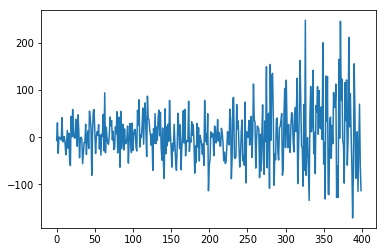

In [19]:
player = Worker(ActorCritic(n_arms, batch_size=50, time_steps=100), 50)
rs = eval_meta_player(player, 500)
plt.plot(rs)

In [ ]:
# how can you fairly evaluate this? 
# we have been training on the test data...!?